In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from hyperopt import hp
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

In [2]:
df = pd.read_csv('./data/3min_series.csv')
target = pd.read_csv('./data/target.csv')

In [3]:
df.head()

,Date,Шум,Обратная ЭДС,Ср.прир.напр.,Сум.доз АПГ,Board Temp. 1,Board Temp. 2,Board Temp. 3,Board Temp. 4,Board Temp. 5,Board Temp. 6,Board Temp. 7,Board Temp. 8,Board Temp. 9,Board Temp. 10,Board Face Temp. 1,Board Face Temp. 6,Board Deaf Temp. 1,Board Deaf Temp. 6
0,30-Jul-18 22:46:00,0.016,2.277,-1.1,7.0,234.0,311.0,285.0,267.0,333.0,316.0,237.0,357.0,322.0,328.0,296.0,295.0,250.0,218.0
1,30-Jul-18 22:49:00,0.014,2.277,-0.8,7.0,236.0,313.0,284.0,270.0,333.0,318.0,243.0,358.0,324.0,328.0,301.0,296.0,253.0,219.0
2,30-Jul-18 22:52:00,0.016,2.277,-0.9,6.0,236.0,312.0,281.0,270.0,331.0,319.0,244.0,357.0,325.0,328.0,301.0,296.0,253.0,219.0
3,30-Jul-18 22:55:00,0.014,2.277,-1.0,7.0,237.0,313.0,283.0,266.0,332.0,317.0,243.0,359.0,325.0,328.0,300.0,296.0,252.0,218.0
4,30-Jul-18 22:58:00,0.017,2.277,-0.8,8.0,236.0,312.0,284.0,265.0,332.0,316.0,241.0,359.0,324.0,329.0,299.0,296.0,253.0,218.0


In [4]:
target.head()

,;product_percents
0,2018-07-28 05:00:00;3.68
1,2018-07-28 14:00:00;3.49
2,2018-07-29 05:00:00;3.61
3,2018-07-29 14:00:00;3.65
4,2018-07-30 05:00:00;3.41


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52269 entries, 0 to 52268
Data columns (total 19 columns):
Date                  52269 non-null object
Шум                   51327 non-null float64
Обратная ЭДС          51327 non-null float64
Ср.прир.напр.         49631 non-null float64
Сум.доз АПГ           51328 non-null float64
Board Temp. 1         50850 non-null float64
Board Temp. 2         50850 non-null float64
Board Temp. 3         50850 non-null float64
Board Temp. 4         50850 non-null float64
Board Temp. 5         50850 non-null float64
Board Temp. 6         50850 non-null float64
Board Temp. 7         50850 non-null float64
Board Temp. 8         50850 non-null float64
Board Temp. 9         50850 non-null float64
Board Temp. 10        50850 non-null float64
Board Face Temp. 1    50850 non-null float64
Board Face Temp. 6    50850 non-null float64
Board Deaf Temp. 1    50850 non-null float64
Board Deaf Temp. 6    50850 non-null float64
dtypes: float64(18), object(1)
memory

In [6]:
target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 166 entries, 0 to 165
Data columns (total 1 columns):
;product_percents    166 non-null object
dtypes: object(1)
memory usage: 1.4+ KB


Преобразуем столбец Date в datetime и разделяем target на две колонки

In [7]:
target['Date'] = target[';product_percents'].apply(lambda x: pd.to_datetime(x.split(';')[0]))
target['product_percents'] = target[';product_percents'].apply(lambda x: float(x.split(';')[1] if x.split(';')[1]\
                                                               else np.nan))
target.drop(';product_percents', axis=1, inplace=True)
target.head()

,Date,product_percents
0,2018-07-28 05:00:00,3.68
1,2018-07-28 14:00:00,3.49
2,2018-07-29 05:00:00,3.61
3,2018-07-29 14:00:00,3.65
4,2018-07-30 05:00:00,3.41


In [8]:
target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 166 entries, 0 to 165
Data columns (total 2 columns):
Date                166 non-null datetime64[ns]
product_percents    131 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.7 KB


In [9]:
df.Date = pd.to_datetime(df.Date)
df.head()

,Date,Шум,Обратная ЭДС,Ср.прир.напр.,Сум.доз АПГ,Board Temp. 1,Board Temp. 2,Board Temp. 3,Board Temp. 4,Board Temp. 5,Board Temp. 6,Board Temp. 7,Board Temp. 8,Board Temp. 9,Board Temp. 10,Board Face Temp. 1,Board Face Temp. 6,Board Deaf Temp. 1,Board Deaf Temp. 6
0,2018-07-30 22:46:00,0.016,2.277,-1.1,7.0,234.0,311.0,285.0,267.0,333.0,316.0,237.0,357.0,322.0,328.0,296.0,295.0,250.0,218.0
1,2018-07-30 22:49:00,0.014,2.277,-0.8,7.0,236.0,313.0,284.0,270.0,333.0,318.0,243.0,358.0,324.0,328.0,301.0,296.0,253.0,219.0
2,2018-07-30 22:52:00,0.016,2.277,-0.9,6.0,236.0,312.0,281.0,270.0,331.0,319.0,244.0,357.0,325.0,328.0,301.0,296.0,253.0,219.0
3,2018-07-30 22:55:00,0.014,2.277,-1.0,7.0,237.0,313.0,283.0,266.0,332.0,317.0,243.0,359.0,325.0,328.0,300.0,296.0,252.0,218.0
4,2018-07-30 22:58:00,0.017,2.277,-0.8,8.0,236.0,312.0,284.0,265.0,332.0,316.0,241.0,359.0,324.0,329.0,299.0,296.0,253.0,218.0


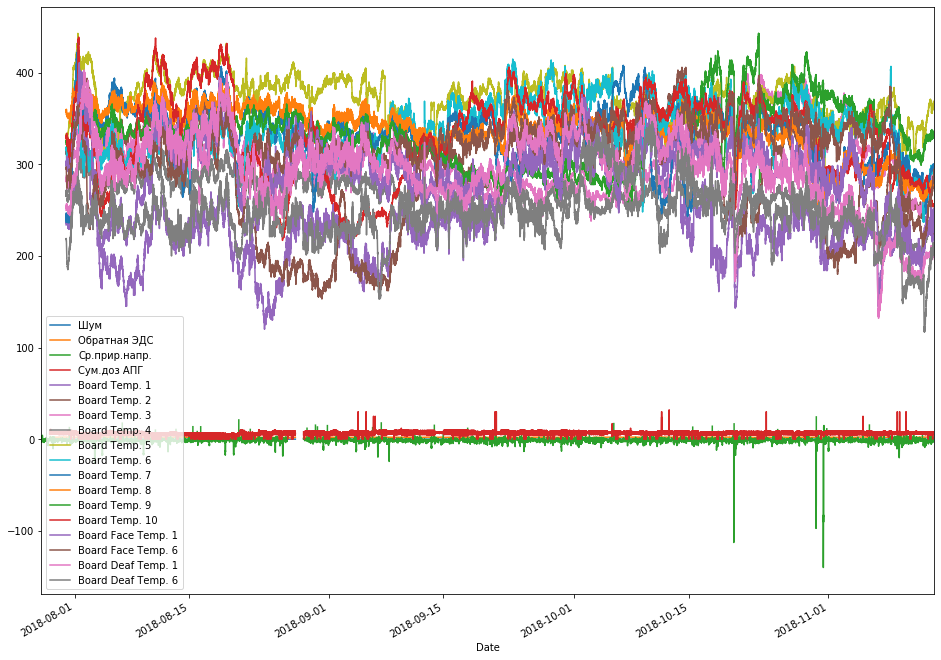

In [10]:
df.set_index('Date').plot(figsize=(16,12))

Так как у нас не совпадают размеры таблиц
#### Идея 1: слепим данные до размера target

In [11]:
row_list = []
for i in target.index:
    dict1 = {}
    if i == 0:
        dict1 = dict({'Date': target.Date[0]})
        dict1.update(dict((col,\
                          df[col][(df.Date <= target.Date[0])\
                                  & (df.loc[:, 'Date'].dt.dayofyear == target.Date[0].dayofyear)].\
                           sum()) for col in df.columns[1:]))
        row_list.append(dict1)
    else:
        dict1 = dict({'Date': target.Date[i]})
        dict1.update(dict((col,\
                          df[col][(df.Date <= target.Date[i]) & (df.Date > target.Date[i-1])].sum())\
                          for col in df.columns[1:]))
        row_list.append(dict1)
        
df1 = pd.DataFrame(row_list, columns=df.columns)
df1.head()

,Date,Шум,Обратная ЭДС,Ср.прир.напр.,Сум.доз АПГ,Board Temp. 1,Board Temp. 2,Board Temp. 3,Board Temp. 4,Board Temp. 5,Board Temp. 6,Board Temp. 7,Board Temp. 8,Board Temp. 9,Board Temp. 10,Board Face Temp. 1,Board Face Temp. 6,Board Deaf Temp. 1,Board Deaf Temp. 6
0,2018-07-28 05:00:00,0.000,0.000,-19.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2018-07-28 14:00:00,0.000,0.000,-195.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2018-07-29 05:00:00,1.374,286.851,-284.5,862.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2018-07-29 14:00:00,2.505,424.357,-372.3,1247.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2018-07-30 05:00:00,4.132,670.235,-370.0,2066.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


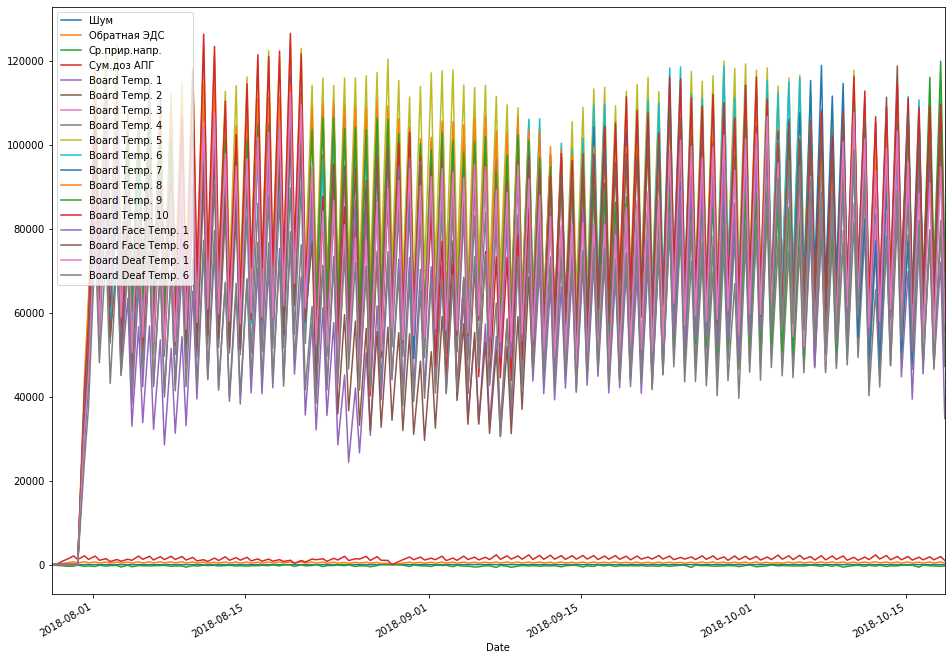

In [12]:
df1.set_index('Date').plot(figsize=(16,12))

Заполним нули в начале

/home/satellite/py37/lib/python3.7/site-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


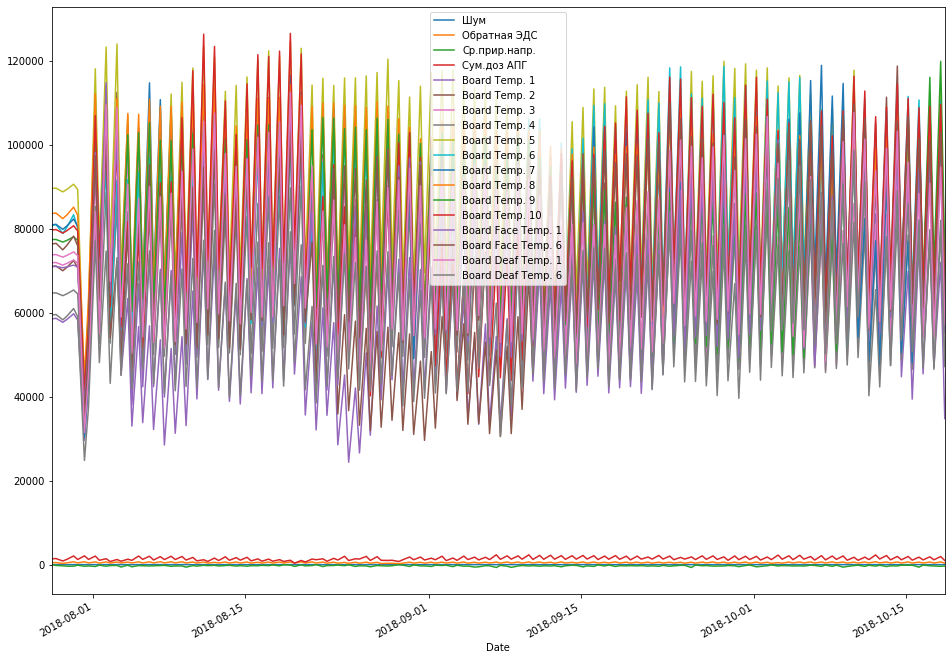

In [13]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

it_imp = IterativeImputer(missing_values=0)
df1_imp = it_imp.fit_transform(df1.loc[:, df1.columns[1:]])
df1_imp = pd.concat([df1.loc[:, 'Date'], pd.DataFrame(df1_imp)], axis=1)
df1_imp.columns = df.columns
df1_imp.set_index('Date').plot(figsize=(16,12))

Не идеально, но лучше, чем 0

Разделяем на тренировочную и тестовую выборки

In [14]:
scaler = StandardScaler()

In [15]:
type(df1_imp[target.product_percents.notna()])

pandas.core.frame.DataFrame

In [16]:
X = scaler.fit_transform(df1_imp.loc[target.product_percents.notna(), df1_imp.columns[1:]])
X_test = scaler.transform(df1_imp.loc[target.product_percents.isna(), df1_imp.columns[1:]])

X_train, X_valid, y_train, y_valid = train_test_split(X,\
                                                      target.loc[target.product_percents.notna(), 'product_percents'],\
                                                      test_size=0.3, shuffle=False) 

In [17]:
clf = Ridge()
clf.fit(X_train, y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [18]:
print("Mean absolute error (train): %.3f" % mean_absolute_error(y_train, clf.predict(X_train)))
print("Mean absolute error (valid): %.3f" % mean_absolute_error(y_valid, clf.predict(X_valid)))

Mean absolute error (train): 0.314
Mean absolute error (valid): 0.384


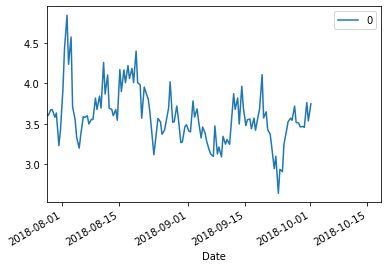

In [19]:
pred = pd.concat([target.Date, pd.DataFrame(clf.predict(X))], axis=1)
pred.set_index('Date').plot()

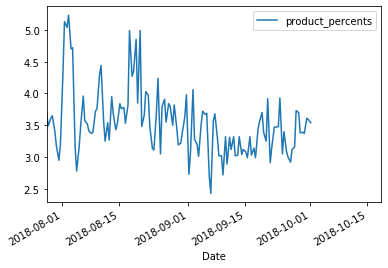

In [20]:
t = target.set_index('Date')
t.plot()

Видно, что качество предсказания даже на тестовой выборке низкое. Данных слишком мало, чтобы адекватно предсказывать целевую переменную. Да и сохранять частоту предсказания в два раза в день не слишком хорошая идея. Хорошо было бы знать значение целевой переменной сразу после каждого измерения. Отсюда переходим к идее2

#### Идея 2: интерполируем значения целевой переменной в моменты между её замерами

In [21]:
row_list = []
for i in range(target.shape[0]-1):
    dict1 = {}
    dates = df['Date'][(df.Date >= target.Date[i]) & (df.Date < target.Date[i+1])]
    pr = np.linspace(target.product_percents[i], target.product_percents[i+1], dates.shape[0]+2)
    for j, k in enumerate(dates.index):
        dict1 = dict({'Date': df.Date[k]})
        dict1.update(dict({'product_percents': pr[j]}))
        row_list.append(dict1)
        
y = pd.DataFrame(row_list, columns=target.columns)
y.head()

,Date,product_percents
0,2018-07-28 08:04:00,3.680000
1,2018-07-28 10:19:00,3.678950
2,2018-07-28 12:04:00,3.677901
3,2018-07-28 13:07:00,3.676851
4,2018-07-28 06:55:00,3.675801


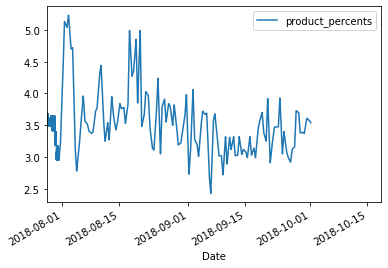

In [22]:
t = y.set_index('Date')
t.plot()

/home/satellite/py37/lib/python3.7/site-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


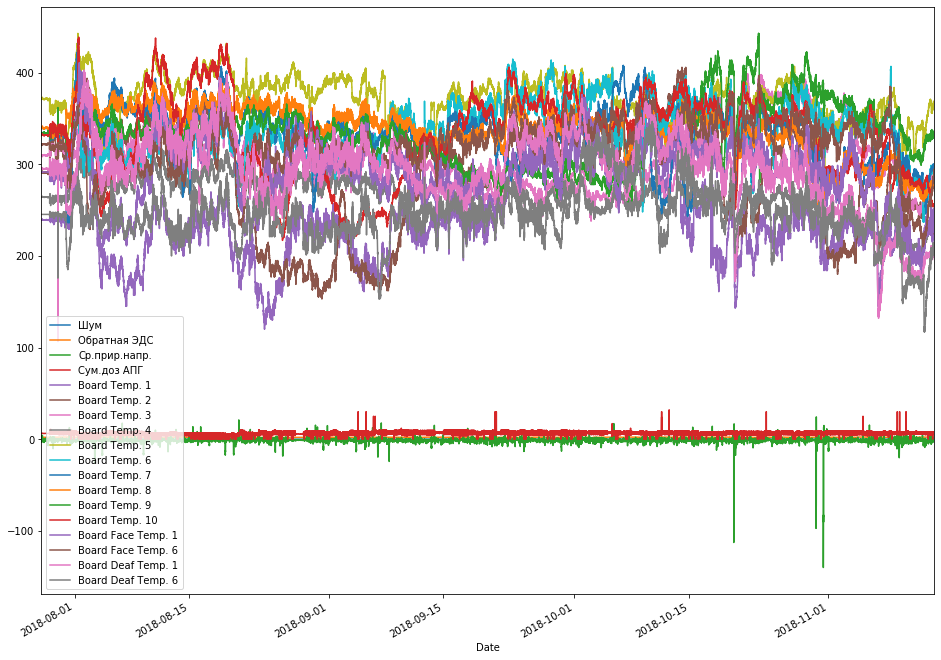

In [23]:
it_imp = IterativeImputer()
df_imp = it_imp.fit_transform(df.loc[:, df.columns[1:]])
df_imp = pd.concat([df.loc[:, 'Date'], pd.DataFrame(df_imp)], axis=1)
df_imp.columns = df.columns
df_imp.set_index('Date').plot(figsize=(16,12))

In [24]:
df2 = df_imp.set_index('Date').loc[y.Date, :]
df2.head()

,Шум,Обратная ЭДС,Ср.прир.напр.,Сум.доз АПГ,Board Temp. 1,Board Temp. 2,Board Temp. 3,Board Temp. 4,Board Temp. 5,Board Temp. 6,Board Temp. 7,Board Temp. 8,Board Temp. 9,Board Temp. 10,Board Face Temp. 1,Board Face Temp. 6,Board Deaf Temp. 1,Board Deaf Temp. 6
Date,,,,,,,,,,,,,,,,,,
2018-07-28 08:04:00,0.010860,2.049973,-0.6,6.315884,239.518505,291.189361,309.810195,264.348734,371.654428,339.052430,333.732298,339.937024,333.973418,332.085921,291.639830,321.795824,295.283353,245.395410
2018-07-28 10:19:00,0.010860,2.049973,-0.6,6.315884,239.518505,291.189361,309.810195,264.348734,371.654428,339.052430,333.732298,339.937024,333.973418,332.085921,291.639830,321.795824,295.283353,245.395410
2018-07-28 12:04:00,0.010830,2.051968,-2.1,6.252781,239.330981,290.665043,310.242633,264.137751,371.162832,339.053811,333.415321,339.315236,334.570754,331.722241,291.704039,322.123927,294.917875,245.387100
2018-07-28 13:07:00,0.010895,2.047580,1.2,6.391608,239.743533,291.818542,309.291269,264.601914,372.244344,339.050773,334.112671,340.683171,333.256614,332.522337,291.562779,321.402102,295.721928,245.405382
2018-07-28 06:55:00,0.010820,2.052632,-2.6,6.231747,239.268473,290.490270,310.386779,264.067424,370.998966,339.054271,333.309662,339.107973,334.769866,331.601014,291.725442,322.233294,294.796049,245.384330


In [25]:
X = scaler.fit_transform(df2.loc[y.set_index('Date').product_percents.notna(), :])
X_test = scaler.transform(df2.loc[y.set_index('Date').product_percents.isna(), :])

X_train, X_valid, y_train, y_valid = train_test_split(X,\
                                                      y.loc[y.product_percents.notna(), 'product_percents'],\
                                                      test_size=0.3, shuffle=False) 

Обучаем несколько моделей, начиная с простых линейных, и выбираем лучшую

In [26]:
clf = RidgeCV(alphas=np.logspace(-6, 6, 13), cv=5, scoring='neg_mean_absolute_error')
clf.fit(X_train, y_train)

RidgeCV(alphas=array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01,
       1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06]),
        cv=5, fit_intercept=True, gcv_mode=None, normalize=False,
        scoring='neg_mean_absolute_error', store_cv_values=False)

In [27]:
print("Mean absolute error (train): %.3f" % mean_absolute_error(y_train, clf.predict(X_train)))
print("Mean absolute error (valid): %.3f" % mean_absolute_error(y_valid, clf.predict(X_valid)))

Mean absolute error (train): 0.245
Mean absolute error (valid): 0.510


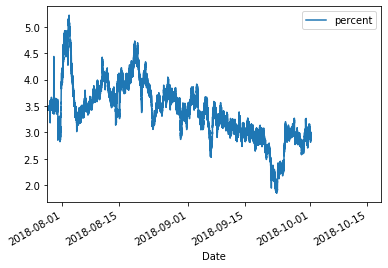

In [28]:
pred1 = pd.concat([y.Date, pd.DataFrame(clf.predict(X), columns=['percent'])], axis=1)
pred1.set_index('Date').plot()

In [29]:
from sklearn.linear_model import ElasticNetCV

regr = ElasticNetCV(cv=5, l1_ratio=[.1, .5, .7, .9, .95, .99, 1], )
regr.fit(X_train, y_train)

ElasticNetCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
             l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1], max_iter=1000,
             n_alphas=100, n_jobs=None, normalize=False, positive=False,
             precompute='auto', random_state=None, selection='cyclic',
             tol=0.0001, verbose=0)

Mean absolute error (train): 0.246
Mean absolute error (valid): 0.472


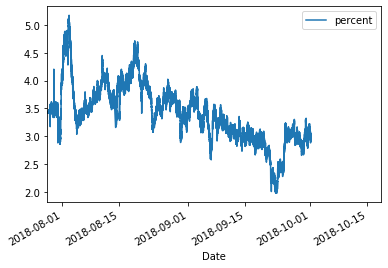

In [30]:
print("Mean absolute error (train): %.3f" % mean_absolute_error(y_train, regr.predict(X_train)))
print("Mean absolute error (valid): %.3f" % mean_absolute_error(y_valid, regr.predict(X_valid)))
pred2 = pd.concat([y.Date, pd.DataFrame(regr.predict(X), columns=['percent'])], axis=1)
pred2.set_index('Date').plot()

In [31]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

rf = RandomForestRegressor(criterion='mse', bootstrap=False)
params = {
    'n_estimators': [100, 500, 1000], 
    'max_depth': [1, 5, 10]
}

gs = GridSearchCV(rf, params, n_jobs=-1, verbose=2, scoring='neg_mean_absolute_error')
gs.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  5.1min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=False, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', 

In [32]:
print("Mean absolute error (train): %.3f" % mean_absolute_error(y_train, gs.predict(X_train)))
print("Mean absolute error (valid): %.3f" % mean_absolute_error(y_valid, gs.predict(X_valid)))

Mean absolute error (train): 0.324
Mean absolute error (valid): 0.248


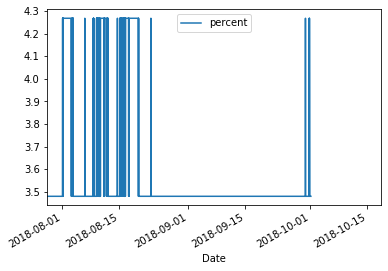

In [33]:
pred3 = pd.concat([y.Date, pd.DataFrame(gs.predict(X), columns=['percent'])], axis=1)
pred3.set_index('Date').plot()

In [34]:
from sklearn.linear_model import HuberRegressor

hr = HuberRegressor()
params = {
    'epsilon': [1.01, 1.35, 1.9], 
    'max_iter': [100, 1000], 
    'alpha': [0.0001, 0.01, 0.1, 1]
}

gs_hr = GridSearchCV(hr, params, n_jobs=-1, verbose=2, scoring='neg_mean_absolute_error')
gs_hr.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    8.4s finished


GridSearchCV(cv=None, error_score=nan,
             estimator=HuberRegressor(alpha=0.0001, epsilon=1.35,
                                      fit_intercept=True, max_iter=100,
                                      tol=1e-05, warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.01, 0.1, 1],
                         'epsilon': [1.01, 1.35, 1.9],
                         'max_iter': [100, 1000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_absolute_error', verbose=2)

Mean absolute error (train): 0.244
Mean absolute error (valid): 0.554


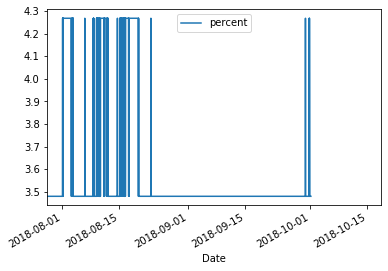

In [35]:
print("Mean absolute error (train): %.3f" % mean_absolute_error(y_train, gs_hr.predict(X_train)))
print("Mean absolute error (valid): %.3f" % mean_absolute_error(y_valid, gs_hr.predict(X_valid)))
pred4 = pd.concat([y.Date, pd.DataFrame(gs.predict(X), columns=['percent'])], axis=1)
pred4.set_index('Date').plot()

In [36]:
def score(params):
    print("Training with params:")
    print(params)
    params['max_depth'] = int(params['max_depth'])
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvalid = xgb.DMatrix(X_valid, label=y_valid)
    model = xgb.train(params, dtrain, params['num_round'])
    predictions = model.predict(dvalid)
    score = mean_absolute_error(y_valid, predictions)
    print("\tScore {0}\n\n".format(score))
    return {'loss': score, 'status': STATUS_OK}

def optimize(trials):
    space = {
             'num_round': 10,
             'learning_rate': hp.quniform('eta', 0.05, 0.9, 0.01),
             'max_depth': hp.quniform('max_depth', 3, 14, 1),
             'min_child_weight': hp.quniform('min_child_weight', 1, 15, 1),
             'num_parallel_tree': hp.choice('num_parallel_tree', range(10, 1500, 10)),
             'eval_metric': 'mae',
             'objective': 'reg:squarederror',
             'nthread' : 8,
             'silent' : 1
             }
    
    best = fmin(score, space, algo=tpe.suggest, trials=trials, max_evals=50)
    return best

trials = Trials()
best_params = optimize(trials)
best_params

Training with params:                                 
{'eval_metric': 'mae', 'learning_rate': 0.85, 'max_depth': 12.0, 'min_child_weight': 11.0, 'nthread': 8, 'num_parallel_tree': 140, 'num_round': 10, 'objective': 'reg:squarederror', 'silent': 1}
  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

/home/satellite/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



	Score 0.3410979689737935                             


Training with params:                                                           
{'eval_metric': 'mae', 'learning_rate': 0.09, 'max_depth': 12.0, 'min_child_weight': 4.0, 'nthread': 8, 'num_parallel_tree': 1480, 'num_round': 10, 'objective': 'reg:squarederror', 'silent': 1}
  2%|▏         | 1/50 [00:19<15:31, 19.01s/trial, best loss: 0.3410979689737935]

/home/satellite/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



	Score 1.2313929976986906                                                       


Training with params:                                                           
{'eval_metric': 'mae', 'learning_rate': 0.8200000000000001, 'max_depth': 10.0, 'min_child_weight': 14.0, 'nthread': 8, 'num_parallel_tree': 940, 'num_round': 10, 'objective': 'reg:squarederror', 'silent': 1}
  4%|▍         | 2/50 [02:41<44:48, 56.01s/trial, best loss: 0.3410979689737935]

/home/satellite/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



	Score 0.37952225896355857                                                      


Training with params:                                                           
{'eval_metric': 'mae', 'learning_rate': 0.3, 'max_depth': 4.0, 'min_child_weight': 9.0, 'nthread': 8, 'num_parallel_tree': 250, 'num_round': 10, 'objective': 'reg:squarederror', 'silent': 1}
  6%|▌         | 3/50 [04:26<55:20, 70.65s/trial, best loss: 0.3410979689737935]

/home/satellite/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



	Score 0.2079253492587739                                                       


Training with params:                                                           
{'eval_metric': 'mae', 'learning_rate': 0.88, 'max_depth': 11.0, 'min_child_weight': 12.0, 'nthread': 8, 'num_parallel_tree': 410, 'num_round': 10, 'objective': 'reg:squarederror', 'silent': 1}
  8%|▊         | 4/50 [04:33<39:33, 51.59s/trial, best loss: 0.2079253492587739]

/home/satellite/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



	Score 0.39051608837360824                                                      


Training with params:                                                           
{'eval_metric': 'mae', 'learning_rate': 0.26, 'max_depth': 9.0, 'min_child_weight': 6.0, 'nthread': 8, 'num_parallel_tree': 880, 'num_round': 10, 'objective': 'reg:squarederror', 'silent': 1}
 10%|█         | 5/50 [05:21<37:59, 50.65s/trial, best loss: 0.2079253492587739]

/home/satellite/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



	Score 0.35641116742926204                                                      


Training with params:                                                           
{'eval_metric': 'mae', 'learning_rate': 0.88, 'max_depth': 10.0, 'min_child_weight': 3.0, 'nthread': 8, 'num_parallel_tree': 860, 'num_round': 10, 'objective': 'reg:squarederror', 'silent': 1}
 12%|█▏        | 6/50 [06:38<42:52, 58.47s/trial, best loss: 0.2079253492587739]

/home/satellite/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



	Score 0.3597838326520326                                                       


Training with params:                                                           
{'eval_metric': 'mae', 'learning_rate': 0.56, 'max_depth': 13.0, 'min_child_weight': 13.0, 'nthread': 8, 'num_parallel_tree': 940, 'num_round': 10, 'objective': 'reg:squarederror', 'silent': 1}
 14%|█▍        | 7/50 [08:12<49:30, 69.07s/trial, best loss: 0.2079253492587739]

/home/satellite/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



	Score 0.24022460271487658                                                      


Training with params:                                                             
{'eval_metric': 'mae', 'learning_rate': 0.26, 'max_depth': 5.0, 'min_child_weight': 1.0, 'nthread': 8, 'num_parallel_tree': 1480, 'num_round': 10, 'objective': 'reg:squarederror', 'silent': 1}
 16%|█▌        | 8/50 [10:31<1:03:07, 90.19s/trial, best loss: 0.2079253492587739]

/home/satellite/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



	Score 0.26241084085810884                                                        


Training with params:                                                             
{'eval_metric': 'mae', 'learning_rate': 0.79, 'max_depth': 13.0, 'min_child_weight': 13.0, 'nthread': 8, 'num_parallel_tree': 730, 'num_round': 10, 'objective': 'reg:squarederror', 'silent': 1}
 18%|█▊        | 9/50 [11:29<55:05, 80.61s/trial, best loss: 0.2079253492587739]

/home/satellite/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



	Score 0.3560912942621669                                                       


Training with params:                                                            
{'eval_metric': 'mae', 'learning_rate': 0.08, 'max_depth': 6.0, 'min_child_weight': 10.0, 'nthread': 8, 'num_parallel_tree': 50, 'num_round': 10, 'objective': 'reg:squarederror', 'silent': 1}
 20%|██        | 10/50 [13:15<58:48, 88.21s/trial, best loss: 0.2079253492587739]

/home/satellite/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



	Score 1.2826131462456645                                                        


Training with params:                                                            
{'eval_metric': 'mae', 'learning_rate': 0.16, 'max_depth': 11.0, 'min_child_weight': 5.0, 'nthread': 8, 'num_parallel_tree': 290, 'num_round': 10, 'objective': 'reg:squarederror', 'silent': 1}
 22%|██▏       | 11/50 [13:18<40:36, 62.47s/trial, best loss: 0.2079253492587739]

/home/satellite/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



	Score 0.6455315849177405                                                        


Training with params:                                                            
{'eval_metric': 'mae', 'learning_rate': 0.6900000000000001, 'max_depth': 9.0, 'min_child_weight': 10.0, 'nthread': 8, 'num_parallel_tree': 900, 'num_round': 10, 'objective': 'reg:squarederror', 'silent': 1}
 24%|██▍       | 12/50 [13:46<33:02, 52.16s/trial, best loss: 0.2079253492587739]

/home/satellite/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



	Score 0.30920529086181514                                                       


Training with params:                                                            
{'eval_metric': 'mae', 'learning_rate': 0.48, 'max_depth': 14.0, 'min_child_weight': 3.0, 'nthread': 8, 'num_parallel_tree': 250, 'num_round': 10, 'objective': 'reg:squarederror', 'silent': 1}
 26%|██▌       | 13/50 [15:08<37:39, 61.07s/trial, best loss: 0.2079253492587739]

/home/satellite/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



	Score 0.28604231259638546                                                       


Training with params:                                                            
{'eval_metric': 'mae', 'learning_rate': 0.42, 'max_depth': 11.0, 'min_child_weight': 3.0, 'nthread': 8, 'num_parallel_tree': 110, 'num_round': 10, 'objective': 'reg:squarederror', 'silent': 1}
 28%|██▊       | 14/50 [15:50<33:11, 55.32s/trial, best loss: 0.2079253492587739]

/home/satellite/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



	Score 0.28739387431052477                                                       


Training with params:                                                            
{'eval_metric': 'mae', 'learning_rate': 0.74, 'max_depth': 6.0, 'min_child_weight': 13.0, 'nthread': 8, 'num_parallel_tree': 460, 'num_round': 10, 'objective': 'reg:squarederror', 'silent': 1}
 30%|███       | 15/50 [16:03<24:54, 42.71s/trial, best loss: 0.2079253492587739]

/home/satellite/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



	Score 0.2955854837555157                                                        


Training with params:                                                            
{'eval_metric': 'mae', 'learning_rate': 0.08, 'max_depth': 8.0, 'min_child_weight': 2.0, 'nthread': 8, 'num_parallel_tree': 280, 'num_round': 10, 'objective': 'reg:squarederror', 'silent': 1}
 32%|███▏      | 16/50 [16:27<20:58, 37.00s/trial, best loss: 0.2079253492587739]

/home/satellite/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



	Score 1.356567133891584                                                         


Training with params:                                                            
{'eval_metric': 'mae', 'learning_rate': 0.23, 'max_depth': 7.0, 'min_child_weight': 11.0, 'nthread': 8, 'num_parallel_tree': 1450, 'num_round': 10, 'objective': 'reg:squarederror', 'silent': 1}
 34%|███▍      | 17/50 [16:46<17:30, 31.83s/trial, best loss: 0.2079253492587739]

/home/satellite/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



	Score 0.30423181606298705                                                       


Training with params:                                                            
{'eval_metric': 'mae', 'learning_rate': 0.8, 'max_depth': 6.0, 'min_child_weight': 6.0, 'nthread': 8, 'num_parallel_tree': 190, 'num_round': 10, 'objective': 'reg:squarederror', 'silent': 1}
 36%|███▌      | 18/50 [18:22<27:10, 50.95s/trial, best loss: 0.2079253492587739]

/home/satellite/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



	Score 0.3464448188186513                                                        


Training with params:                                                            
{'eval_metric': 'mae', 'learning_rate': 0.41000000000000003, 'max_depth': 7.0, 'min_child_weight': 7.0, 'nthread': 8, 'num_parallel_tree': 110, 'num_round': 10, 'objective': 'reg:squarederror', 'silent': 1}
 38%|███▊      | 19/50 [18:32<19:55, 38.57s/trial, best loss: 0.2079253492587739]

/home/satellite/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



	Score 0.2340332589104216                                                        


Training with params:                                                            
{'eval_metric': 'mae', 'learning_rate': 0.34, 'max_depth': 4.0, 'min_child_weight': 8.0, 'nthread': 8, 'num_parallel_tree': 1250, 'num_round': 10, 'objective': 'reg:squarederror', 'silent': 1}
 40%|████      | 20/50 [18:39<14:31, 29.06s/trial, best loss: 0.2079253492587739]

/home/satellite/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



	Score 0.1860438707946447                                                        


Training with params:                                                            
{'eval_metric': 'mae', 'learning_rate': 0.35000000000000003, 'max_depth': 3.0, 'min_child_weight': 9.0, 'nthread': 8, 'num_parallel_tree': 120, 'num_round': 10, 'objective': 'reg:squarederror', 'silent': 1}
 42%|████▏     | 21/50 [19:14<14:55, 30.88s/trial, best loss: 0.1860438707946447]

/home/satellite/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



	Score 0.19123839089861114                                                       


Training with params:                                                            
{'eval_metric': 'mae', 'learning_rate': 0.35000000000000003, 'max_depth': 3.0, 'min_child_weight': 8.0, 'nthread': 8, 'num_parallel_tree': 90, 'num_round': 10, 'objective': 'reg:squarederror', 'silent': 1}
 44%|████▍     | 22/50 [19:16<10:25, 22.33s/trial, best loss: 0.1860438707946447]

/home/satellite/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



	Score 0.19123483156609342                                                       


Training with params:                                                            
{'eval_metric': 'mae', 'learning_rate': 0.5700000000000001, 'max_depth': 3.0, 'min_child_weight': 8.0, 'nthread': 8, 'num_parallel_tree': 90, 'num_round': 10, 'objective': 'reg:squarederror', 'silent': 1}
 46%|████▌     | 23/50 [19:18<07:16, 16.17s/trial, best loss: 0.1860438707946447]

/home/satellite/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



	Score 0.2174523638975995                                                        


Training with params:                                                            
{'eval_metric': 'mae', 'learning_rate': 0.17, 'max_depth': 4.0, 'min_child_weight': 7.0, 'nthread': 8, 'num_parallel_tree': 1240, 'num_round': 10, 'objective': 'reg:squarederror', 'silent': 1}
 48%|████▊     | 24/50 [19:20<05:08, 11.87s/trial, best loss: 0.1860438707946447]

/home/satellite/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



	Score 0.43144830746453244                                                       


Training with params:                                                            
{'eval_metric': 'mae', 'learning_rate': 0.53, 'max_depth': 4.0, 'min_child_weight': 8.0, 'nthread': 8, 'num_parallel_tree': 40, 'num_round': 10, 'objective': 'reg:squarederror', 'silent': 1}
 50%|█████     | 25/50 [19:55<07:50, 18.83s/trial, best loss: 0.1860438707946447]

/home/satellite/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



	Score 0.19439502317013754                                                       


Training with params:                                                            
{'eval_metric': 'mae', 'learning_rate': 0.64, 'max_depth': 5.0, 'min_child_weight': 5.0, 'nthread': 8, 'num_parallel_tree': 1250, 'num_round': 10, 'objective': 'reg:squarederror', 'silent': 1}
 52%|█████▏    | 26/50 [19:56<05:24, 13.54s/trial, best loss: 0.1860438707946447]

/home/satellite/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



	Score 0.3667281445972222                                                        


Training with params:                                                            
{'eval_metric': 'mae', 'learning_rate': 0.37, 'max_depth': 3.0, 'min_child_weight': 9.0, 'nthread': 8, 'num_parallel_tree': 1430, 'num_round': 10, 'objective': 'reg:squarederror', 'silent': 1}
 54%|█████▍    | 27/50 [20:45<09:13, 24.08s/trial, best loss: 0.1860438707946447]

/home/satellite/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



	Score 0.20837489676688542                                                       


Training with params:                                                            
{'eval_metric': 'mae', 'learning_rate': 0.47000000000000003, 'max_depth': 5.0, 'min_child_weight': 11.0, 'nthread': 8, 'num_parallel_tree': 910, 'num_round': 10, 'objective': 'reg:squarederror', 'silent': 1}
 56%|█████▌    | 28/50 [21:13<09:14, 25.22s/trial, best loss: 0.1860438707946447]

/home/satellite/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



	Score 0.33881821548655533                                                       


Training with params:                                                            
{'eval_metric': 'mae', 'learning_rate': 0.33, 'max_depth': 4.0, 'min_child_weight': 7.0, 'nthread': 8, 'num_parallel_tree': 1460, 'num_round': 10, 'objective': 'reg:squarederror', 'silent': 1}
 58%|█████▊    | 29/50 [21:48<09:52, 28.20s/trial, best loss: 0.1860438707946447]

/home/satellite/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



	Score 0.1821869320124565                                                        


Training with params:                                                            
{'eval_metric': 'mae', 'learning_rate': 0.16, 'max_depth': 7.0, 'min_child_weight': 6.0, 'nthread': 8, 'num_parallel_tree': 1460, 'num_round': 10, 'objective': 'reg:squarederror', 'silent': 1}
 60%|██████    | 30/50 [22:29<10:43, 32.16s/trial, best loss: 0.1821869320124565]

/home/satellite/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



	Score 0.5978071721290165                                                        


Training with params:                                                            
{'eval_metric': 'mae', 'learning_rate': 0.21, 'max_depth': 4.0, 'min_child_weight': 5.0, 'nthread': 8, 'num_parallel_tree': 360, 'num_round': 10, 'objective': 'reg:squarederror', 'silent': 1}
 62%|██████▏   | 31/50 [23:59<15:42, 49.61s/trial, best loss: 0.1821869320124565]

/home/satellite/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



	Score 0.24887079486694266                                                       


Training with params:                                                            
{'eval_metric': 'mae', 'learning_rate': 0.3, 'max_depth': 8.0, 'min_child_weight': 7.0, 'nthread': 8, 'num_parallel_tree': 450, 'num_round': 10, 'objective': 'reg:squarederror', 'silent': 1}
 64%|██████▍   | 32/50 [24:09<11:18, 37.71s/trial, best loss: 0.1821869320124565]

/home/satellite/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



	Score 0.2547924035382494                                                        


Training with params:                                                            
{'eval_metric': 'mae', 'learning_rate': 0.48, 'max_depth': 5.0, 'min_child_weight': 4.0, 'nthread': 8, 'num_parallel_tree': 500, 'num_round': 10, 'objective': 'reg:squarederror', 'silent': 1}
 66%|██████▌   | 33/50 [24:45<10:31, 37.17s/trial, best loss: 0.1821869320124565]

/home/satellite/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



	Score 0.2907942240587896                                                        


Training with params:                                                            
{'eval_metric': 'mae', 'learning_rate': 0.29, 'max_depth': 4.0, 'min_child_weight': 10.0, 'nthread': 8, 'num_parallel_tree': 870, 'num_round': 10, 'objective': 'reg:squarederror', 'silent': 1}
 68%|██████▊   | 34/50 [25:04<08:27, 31.72s/trial, best loss: 0.1821869320124565]

/home/satellite/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



	Score 0.19274310991279103                                                       


Training with params:                                                            
{'eval_metric': 'mae', 'learning_rate': 0.63, 'max_depth': 6.0, 'min_child_weight': 12.0, 'nthread': 8, 'num_parallel_tree': 210, 'num_round': 10, 'objective': 'reg:squarederror', 'silent': 1}
 70%|███████   | 35/50 [25:29<07:23, 29.58s/trial, best loss: 0.1821869320124565]

/home/satellite/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



	Score 0.22519215733025752                                                       


Training with params:                                                            
{'eval_metric': 'mae', 'learning_rate': 0.4, 'max_depth': 8.0, 'min_child_weight': 4.0, 'nthread': 8, 'num_parallel_tree': 1060, 'num_round': 10, 'objective': 'reg:squarederror', 'silent': 1}
 72%|███████▏  | 36/50 [25:39<05:33, 23.84s/trial, best loss: 0.1821869320124565]

/home/satellite/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



	Score 0.2006422249065239                                                        


Training with params:                                                            
{'eval_metric': 'mae', 'learning_rate': 0.12, 'max_depth': 10.0, 'min_child_weight': 6.0, 'nthread': 8, 'num_parallel_tree': 530, 'num_round': 10, 'objective': 'reg:squarederror', 'silent': 1}
 74%|███████▍  | 37/50 [27:05<09:11, 42.40s/trial, best loss: 0.1821869320124565]

/home/satellite/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



	Score 0.9176796953860654                                                        


Training with params:                                                            
{'eval_metric': 'mae', 'learning_rate': 0.22, 'max_depth': 5.0, 'min_child_weight': 15.0, 'nthread': 8, 'num_parallel_tree': 1250, 'num_round': 10, 'objective': 'reg:squarederror', 'silent': 1}
 76%|███████▌  | 38/50 [27:51<08:40, 43.37s/trial, best loss: 0.1821869320124565]

/home/satellite/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



	Score 0.34843571237320725                                                       


Training with params:                                                            
{'eval_metric': 'mae', 'learning_rate': 0.05, 'max_depth': 9.0, 'min_child_weight': 9.0, 'nthread': 8, 'num_parallel_tree': 700, 'num_round': 10, 'objective': 'reg:squarederror', 'silent': 1}
 78%|███████▊  | 39/50 [28:39<08:14, 44.93s/trial, best loss: 0.1821869320124565]

/home/satellite/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



	Score 1.7790270128141124                                                        


Training with params:                                                            
{'eval_metric': 'mae', 'learning_rate': 0.31, 'max_depth': 4.0, 'min_child_weight': 12.0, 'nthread': 8, 'num_parallel_tree': 1020, 'num_round': 10, 'objective': 'reg:squarederror', 'silent': 1}
 80%|████████  | 40/50 [29:34<07:58, 47.87s/trial, best loss: 0.1821869320124565]

/home/satellite/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



	Score 0.1887631412813265                                                        


Training with params:                                                            
{'eval_metric': 'mae', 'learning_rate': 0.44, 'max_depth': 7.0, 'min_child_weight': 1.0, 'nthread': 8, 'num_parallel_tree': 960, 'num_round': 10, 'objective': 'reg:squarederror', 'silent': 1}
 82%|████████▏ | 41/50 [30:02<06:18, 42.02s/trial, best loss: 0.1821869320124565]

/home/satellite/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



	Score 0.23841781242701215                                                       


Training with params:                                                            
{'eval_metric': 'mae', 'learning_rate': 0.54, 'max_depth': 6.0, 'min_child_weight': 15.0, 'nthread': 8, 'num_parallel_tree': 1080, 'num_round': 10, 'objective': 'reg:squarederror', 'silent': 1}
 84%|████████▍ | 42/50 [31:06<06:27, 48.41s/trial, best loss: 0.1821869320124565]

/home/satellite/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



	Score 0.21967891779736748                                                       


Training with params:                                                            
{'eval_metric': 'mae', 'learning_rate': 0.12, 'max_depth': 3.0, 'min_child_weight': 7.0, 'nthread': 8, 'num_parallel_tree': 1120, 'num_round': 10, 'objective': 'reg:squarederror', 'silent': 1}
 86%|████████▌ | 43/50 [32:00<05:50, 50.07s/trial, best loss: 0.1821869320124565]

/home/satellite/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



	Score 0.7363798735632113                                                        


Training with params:                                                            
{'eval_metric': 'mae', 'learning_rate': 0.6, 'max_depth': 5.0, 'min_child_weight': 10.0, 'nthread': 8, 'num_parallel_tree': 470, 'num_round': 10, 'objective': 'reg:squarederror', 'silent': 1}
 88%|████████▊ | 44/50 [32:21<04:09, 41.59s/trial, best loss: 0.1821869320124565]

/home/satellite/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



	Score 0.31436695484658245                                                       


Training with params:                                                            
{'eval_metric': 'mae', 'learning_rate': 0.51, 'max_depth': 12.0, 'min_child_weight': 2.0, 'nthread': 8, 'num_parallel_tree': 270, 'num_round': 10, 'objective': 'reg:squarederror', 'silent': 1}
 90%|█████████ | 45/50 [32:40<02:52, 34.59s/trial, best loss: 0.1821869320124565]

/home/satellite/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



	Score 0.2442568742417551                                                        


Training with params:                                                            
{'eval_metric': 'mae', 'learning_rate': 0.26, 'max_depth': 10.0, 'min_child_weight': 4.0, 'nthread': 8, 'num_parallel_tree': 710, 'num_round': 10, 'objective': 'reg:squarederror', 'silent': 1}
 92%|█████████▏| 46/50 [33:17<02:21, 35.48s/trial, best loss: 0.1821869320124565]

/home/satellite/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



	Score 0.31650567761415377                                                       


Training with params:                                                            
{'eval_metric': 'mae', 'learning_rate': 0.33, 'max_depth': 13.0, 'min_child_weight': 9.0, 'nthread': 8, 'num_parallel_tree': 130, 'num_round': 10, 'objective': 'reg:squarederror', 'silent': 1}
 94%|█████████▍| 47/50 [34:28<02:18, 46.08s/trial, best loss: 0.1821869320124565]

/home/satellite/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



	Score 0.24769333048185513                                                       


Training with params:                                                            
{'eval_metric': 'mae', 'learning_rate': 0.19, 'max_depth': 9.0, 'min_child_weight': 14.0, 'nthread': 8, 'num_parallel_tree': 970, 'num_round': 10, 'objective': 'reg:squarederror', 'silent': 1}
 96%|█████████▌| 48/50 [34:45<01:14, 37.47s/trial, best loss: 0.1821869320124565]

/home/satellite/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



	Score 0.4497623710753287                                                        


Training with params:                                                            
{'eval_metric': 'mae', 'learning_rate': 0.38, 'max_depth': 4.0, 'min_child_weight': 5.0, 'nthread': 8, 'num_parallel_tree': 1460, 'num_round': 10, 'objective': 'reg:squarederror', 'silent': 1}
 98%|█████████▊| 49/50 [36:06<00:50, 50.28s/trial, best loss: 0.1821869320124565]

/home/satellite/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



	Score 0.18019736436107356                                                       


100%|██████████| 50/50 [36:48<00:00, 44.17s/trial, best loss: 0.18019736436107356]


{'eta': 0.38,
 'max_depth': 4.0,
 'min_child_weight': 5.0,
 'num_parallel_tree': 145}

In [37]:
best_params['max_depth'] = int(best_params['max_depth'])
best_params['eval_metric'] = 'mae'
best_params['objective'] = 'reg:squarederror'
best_params['nthread'] = 8
best_params['silent'] = 1

In [38]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_valid, label=y_valid)
watchlist  = [(dtrain,'train'), (dvalid,'valid')]
xgb_model = xgb.train(best_params, dtrain, 500, watchlist, early_stopping_rounds=50)

/home/satellite/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-mae:1.94626	valid-mae:1.82594
Multiple eval metrics have been passed: 'valid-mae' will be used for early stopping.

Will train until valid-mae hasn't improved in 50 rounds.
[1]	train-mae:1.20718	valid-mae:1.05442
[2]	train-mae:0.748862	valid-mae:0.615164
[3]	train-mae:0.470646	valid-mae:0.34457
[4]	train-mae:0.310014	valid-mae:0.251028
[5]	train-mae:0.227734	valid-mae:0.197511
[6]	train-mae:0.183956	valid-mae:0.19096
[7]	train-mae:0.162017	valid-mae:0.181606
[8]	train-mae:0.151671	valid-mae:0.179049
[9]	train-mae:0.142194	valid-mae:0.180168
[10]	train-mae:0.137567	valid-mae:0.183047
[11]	train-mae:0.13376	valid-mae:0.182334
[12]	train-mae:0.12655	valid-mae:0.184654
[13]	train-mae:0.123852	valid-mae:0.184594
[14]	train-mae:0.119477	valid-mae:0.186118
[15]	train-mae:0.115569	valid-mae:0.186764
[16]	train-mae:0.110803	valid-mae:0.192676
[17]	train-mae:0.106928	valid-mae:0.196978
[18]	train-mae:0.104428	valid-mae:0.197366
[19]	train-mae:0.101355	valid-mae:0.199258
[20]	train-mae:

Mean absolute error (train): 0.162
Mean absolute error (valid): 0.182


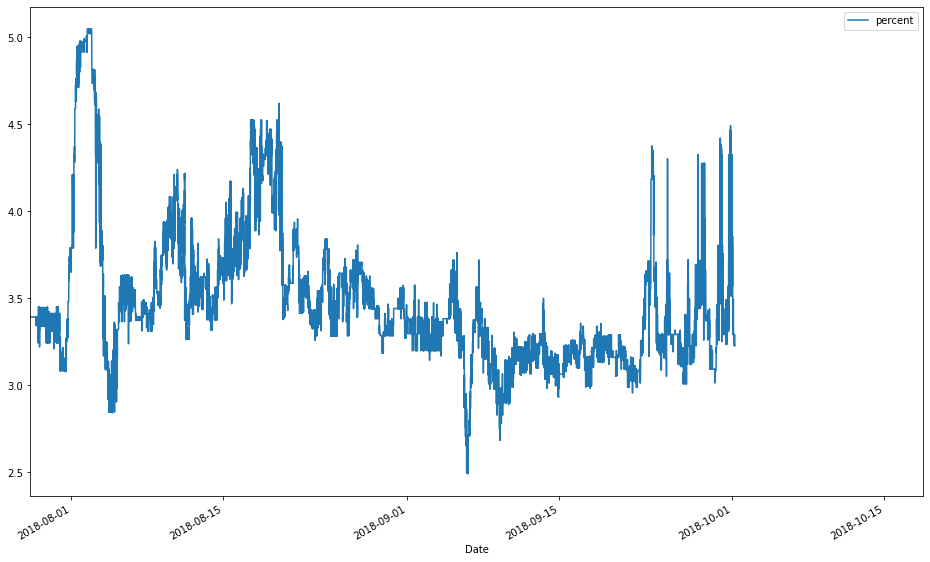

In [46]:
print("Mean absolute error (train): %.3f" % mean_absolute_error(y_train, xgb_model.predict(dtrain)))
print("Mean absolute error (valid): %.3f" % mean_absolute_error(y_valid, xgb_model.predict(dvalid)))
pred5 = pd.concat([y.Date, pd.DataFrame(xgb_model.predict(xgb.DMatrix(X)), columns=['percent'])], axis=1)
pred5.set_index('Date').plot()

Сравниваем графики предсказаний всех моделей

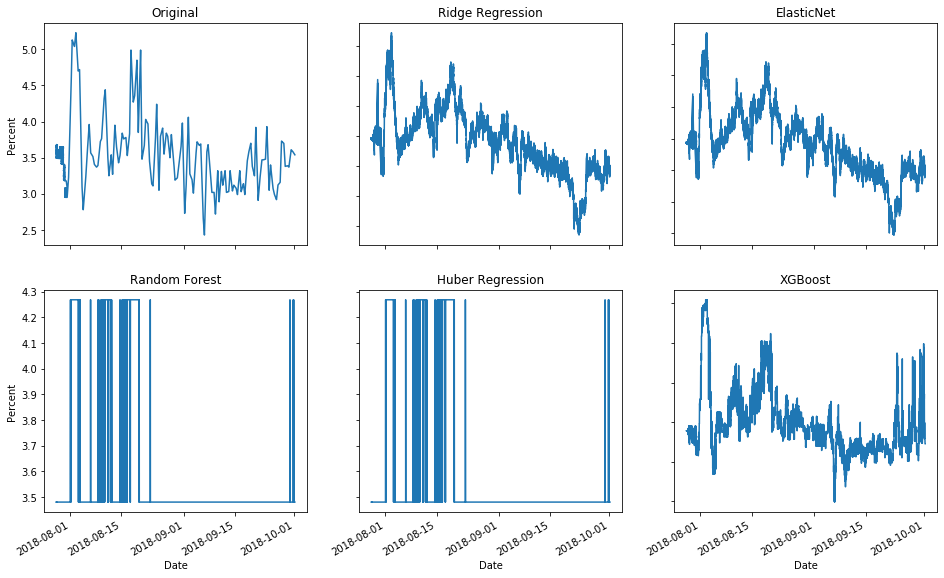

In [47]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (16, 10)

fig, ax = plt.subplots(2, 3)
ax[0, 0].plot(y.set_index('Date'))
ax[0, 0].set_title('Original')
ax[0, 1].plot(pred1.set_index('Date'))
ax[0, 1].set_title('Ridge Regression')
ax[0, 2].plot(pred2.set_index('Date'))
ax[0, 2].set_title('ElasticNet')
ax[1, 0].plot(pred3.set_index('Date'))
ax[1, 0].set_title('Random Forest')
ax[1, 1].plot(pred4.set_index('Date'))
ax[1, 1].set_title('Huber Regression')
ax[1, 2].plot(pred5.set_index('Date'))
ax[1, 2].set_title('XGBoost')

for a in ax.flat:
    a.set(xlabel='Date', ylabel='Percent')
    a.label_outer()
    
fig.autofmt_xdate()

Сравниваем абсолютную ошибку

In [48]:
print("Mean absolute error (valid): %.3f" % mean_absolute_error(y_valid, clf.predict(X_valid)))
print("Mean absolute error (valid): %.3f" % mean_absolute_error(y_valid, regr.predict(X_valid)))
print("Mean absolute error (valid): %.3f" % mean_absolute_error(y_valid, gs.predict(X_valid)))
print("Mean absolute error (valid): %.3f" % mean_absolute_error(y_valid, gs_hr.predict(X_valid)))
print("Mean absolute error (valid): %.3f" % mean_absolute_error(y_valid, xgb_model.predict(dvalid)))

Mean absolute error (valid): 0.510
Mean absolute error (valid): 0.472
Mean absolute error (valid): 0.248
Mean absolute error (valid): 0.554
Mean absolute error (valid): 0.182


In [53]:
print('Ошибка лучшего из рассмотренных алгоритмов составляет: ' + 
      str(mean_absolute_error(y_valid, xgb_model.predict(dvalid)) / (max(y.product_percents) 
                                                                     - min(y.product_percents)) * 100) + '%')

Ошибка лучшего из рассмотренных алгоритмов составляет: 6.485866839546195%


#### Выводы:
1. Модели случайного леса и регрессии Губера в большинства случаев предсказывают значение 3,5%.
2. Линейные модели в общем улавливают изменения количества продукта, но дают высокую абсолютную ошибку.
3. Модель XGBoost улавливает направление изменения количества продукта и даёт наименьшую ошибку из всех испытанных подходов

Обучаем алгоритм, показавший лучшие результаты, на всей выборке и делаем предсказание на тесте

In [55]:
# фиксируем количество раундов = 8, так как проверка проведенная выше показала, что дальше модель переобучается
best_model = xgb.train(best_params, xgb.DMatrix(X, label=y.loc[y.product_percents.notna(), 'product_percents']), 8)

/home/satellite/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


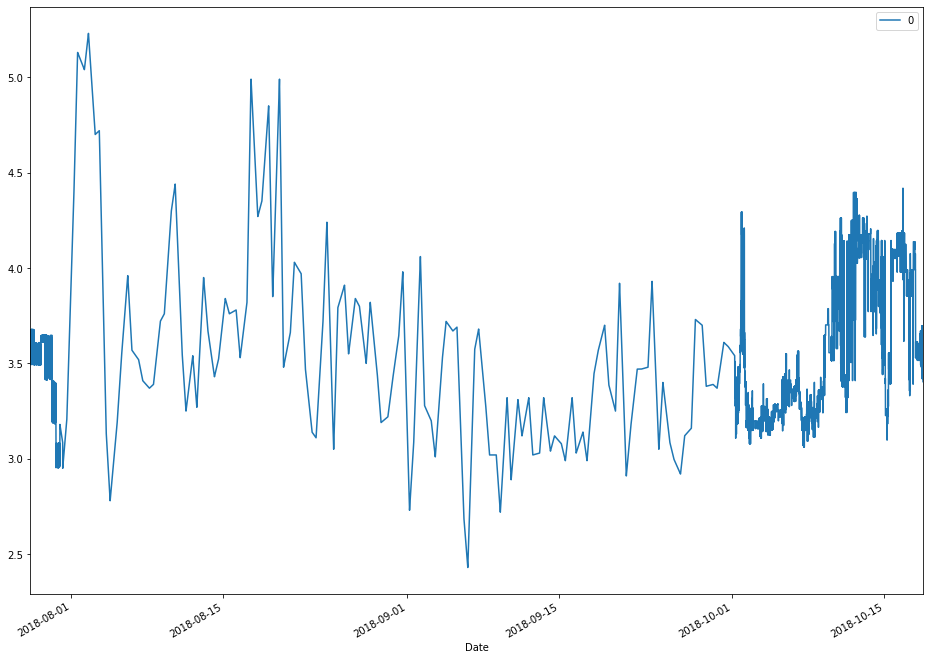

In [56]:
test_pred = best_model.predict(xgb.DMatrix(X_test))

pd.concat([y.Date, 
           pd.concat([y.loc[y.product_percents.notna(), 'product_percents'],
                      pd.DataFrame(test_pred)], axis=0).reset_index(drop=True)], axis=1).\
set_index('Date').plot(figsize=(16,12))

#### Для использования модели в скрипте

Сохраняем лучшую модель и скейлер

In [60]:
import pickle

filename = './data/finalized_model.pkl'
pickle.dump((scaler, best_model), open(filename, 'wb'))

Сохраняем тестовые данные для проверки

In [59]:
df.loc[df.Date >= target.Date[target.product_percents.isna()].values[0], df.columns[1:]].dropna().\
to_csv('./data/data_to_predict.csv', index=False)